### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde

### Utility Function for Computing the Empirical Cumulative Distribution (ECDF)

In [2]:
def ecdf(data):
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n + 1) / n
    return x, y


### SEE Estimator Function

- This is converted from the provided R code

In [3]:
def see_estimator(category, df):
    # Filter by the given category (e.g., "medA")
    df_cat = df[df['CATEGORY'] == category].copy()
    
    # Convert DATE column to datetime
    df_cat['DATE'] = pd.to_datetime(df_cat['DATE'], format='%m/%d/%Y')
    
    # Sort by patient and date
    df_cat.sort_values(by=['PATIENT_ID', 'DATE'], inplace=True)
    
    # Create a column for the previous fill date per patient
    df_cat['prev_DATE'] = df_cat.groupby('PATIENT_ID')['DATE'].shift(1)
    
    # Keep only rows where a previous date exists
    df_sample = df_cat.dropna(subset=['prev_DATE']).copy()
    
    # For each patient, randomly select one pair of consecutive prescriptions
    df_sample = df_sample.groupby('PATIENT_ID').apply(lambda x: x.sample(1, random_state=1234)).reset_index(drop=True)
    
    # Keep only the needed columns
    df_sample = df_sample[['PATIENT_ID', 'DATE', 'prev_DATE']].copy()
    
    # Compute the event interval (in days) between consecutive prescriptions
    df_sample['event_interval'] = (df_sample['DATE'] - df_sample['prev_DATE']).dt.days.astype(float)
    
    # Compute the ECDF for event_interval
    x_ecdf, y_ecdf = ecdf(df_sample['event_interval'].values)
    df_ecdf = pd.DataFrame({'x': x_ecdf, 'y': y_ecdf})
    
    # Plot the 80% ECDF (where y <= 0.8) and the full ECDF
    df_ecdf_80 = df_ecdf[df_ecdf['y'] <= 0.8]
    ni = df_ecdf_80['x'].max()  # maximum x-value in the lower 80%
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(df_ecdf_80['x'], df_ecdf_80['y'], marker='.', linestyle='none')
    plt.title('80% ECDF')
    plt.xlabel('Event Interval (days)')
    plt.ylabel('ECDF')
    
    plt.subplot(1, 2, 2)
    plt.plot(df_ecdf['x'], df_ecdf['y'], marker='.', linestyle='none')
    plt.title('100% ECDF')
    plt.xlabel('Event Interval (days)')
    plt.ylabel('ECDF')
    plt.tight_layout()
    plt.show()
    
    # (Optional) Bar plot of prescription counts per patient (from the sampled data)
    counts = df_sample['PATIENT_ID'].value_counts()
    plt.figure()
    counts.plot(kind='bar')
    plt.title('Number of Sampled Prescription Pairs per Patient')
    plt.xlabel('PATIENT_ID')
    plt.ylabel('Count')
    plt.show()
    
    # Keep only those rows with event_interval less than or equal to ni
    df_filtered = df_sample[df_sample['event_interval'] <= ni].copy()
    
    # Density estimation on the log-transformed event_interval
    log_intervals = np.log(df_filtered['event_interval'])
    kde = gaussian_kde(log_intervals)
    x1 = np.linspace(log_intervals.min(), log_intervals.max(), 100)
    y1 = kde(x1)
    
    plt.figure()
    plt.plot(x1, y1)
    plt.title('Density of log(event_interval)')
    plt.xlabel('log(Event Interval)')
    plt.ylabel('Density')
    plt.show()
    
    # Prepare density data for silhouette analysis
    a = np.column_stack((x1, y1))
    scaler = StandardScaler()
    a_scaled = scaler.fit_transform(a)
    
    # Determine optimal number of clusters using silhouette scores
    best_k = 2
    best_score = -1
    for k in range(2, 11):
        kmeans_temp = KMeans(n_clusters=k, random_state=1234)
        labels = kmeans_temp.fit_predict(a_scaled)
        score = silhouette_score(a_scaled, labels)
        if score > best_score:
            best_score = score
            best_k = k
    print("Optimal number of clusters (silhouette analysis):", best_k)
    
    # K-means clustering on the ECDF x values (event_interval values from df_ecdf)
    kmeans_final = KMeans(n_clusters=best_k, random_state=1234)
    df_ecdf['cluster'] = kmeans_final.fit_predict(df_ecdf[['x']])
    
    # For each cluster, compute the min, max, and median of log(x), then exponentiate to revert to days
    cluster_stats = df_ecdf.groupby('cluster')['x'].agg(
        min_log=lambda x: np.log(x).min(),
        max_log=lambda x: np.log(x).max(),
        median_log=lambda x: np.log(x).median()
    ).reset_index()
    cluster_stats['Minimum'] = np.exp(cluster_stats['min_log'])
    cluster_stats['Maximum'] = np.exp(cluster_stats['max_log'])
    cluster_stats['Median'] = np.exp(cluster_stats['median_log'])
    # Keep only clusters with a positive median
    cluster_stats = cluster_stats[cluster_stats['Median'] > 0]
    
    print("Cluster Statistics:")
    print(cluster_stats[['cluster', 'Minimum', 'Maximum', 'Median']])
    
    # Function to assign a cluster based on an event_interval value
    def assign_cluster(interval):
        for _, row in cluster_stats.iterrows():
            if interval >= row['Minimum'] and interval <= row['Maximum']:
                return row['cluster']
        return np.nan
    
    df_sample['Final_cluster'] = df_sample['event_interval'].apply(assign_cluster)
    df_sample = df_sample.dropna(subset=['Final_cluster']).copy()
    
    # Merge the cluster median (estimated duration) into df_sample
    df_sample = df_sample.merge(cluster_stats[['cluster', 'Median']], left_on='Final_cluster', right_on='cluster', how='left', suffixes=('', '_cluster'))
    
    # Determine the most frequent cluster among the sampled pairs
    if not df_sample.empty:
        most_freq_cluster = df_sample['Final_cluster'].value_counts().idxmax()
        default_median = cluster_stats.loc[cluster_stats['cluster'] == most_freq_cluster, 'Median'].values[0]
    else:
        default_median = np.nan
    
    # Use the computed median as the estimated duration
    df_sample['Median_est'] = df_sample['Median'].fillna(default_median)
    
    # Merge the estimated duration back into the original category dataset
    df_result = df_cat.merge(df_sample[['PATIENT_ID', 'Median_est', 'Final_cluster']], on='PATIENT_ID', how='left')
    df_result['Median_est'] = df_result['Median_est'].fillna(default_median)
    df_result['Final_cluster'] = df_result['Final_cluster'].fillna(0)
    
    return df_result


### SEE Assumption Visualization Function


In [4]:
def see_assumption(df):
    # Convert DATE to datetime
    df['DATE'] = pd.to_datetime(df['DATE'], format='%m/%d/%Y')
    
    # Sort data by patient and date
    df_sorted = df.sort_values(by=['PATIENT_ID', 'DATE']).copy()
    
    # Create a sequential prescription number for each patient
    df_sorted['p_number'] = df_sorted.groupby('PATIENT_ID').cumcount() + 1
    
    # Compute the previous date and the duration between prescriptions
    df_sorted['prev_DATE'] = df_sorted.groupby('PATIENT_ID')['DATE'].shift(1)
    df_sorted['Duration'] = (df_sorted['DATE'] - df_sorted['prev_DATE']).dt.days
    
    # Retain only rows where p_number is 2 or more
    df_assump = df_sorted[df_sorted['p_number'] >= 2].copy()
    
    # Compute median duration per patient
    medians_of_medians = df_assump.groupby('PATIENT_ID')['Duration'].median().reset_index(name='median_duration')
    
    # Plot a boxplot of Duration by prescription order with a horizontal line at the overall median
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='p_number', y='Duration', data=df_assump)
    overall_median = medians_of_medians['median_duration'].median()
    plt.axhline(y=overall_median, linestyle='--', color='red', label=f'Overall median = {overall_median:.1f}')
    plt.title('Duration by Prescription Order')
    plt.xlabel('Prescription Order (p_number)')
    plt.ylabel('Duration (days)')
    plt.legend()
    plt.show()
    
    return plt.gcf()


### Loading of Data and Running of SEE Functions

   PATIENT_ID        DATE  PERDAY CATEGORY  DURATION
0           1  04/26/2033       4     medA        50
1           1  07/04/2033       4     medB        30
2           1  08/03/2033       4     medB        30
3           1  08/17/2033       4     medB        30
4           1  10/13/2033       4     medB        30


C:\Users\Aris\AppData\Local\Temp\ipykernel_14900\4141963939.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = df_sample.groupby('PATIENT_ID').apply(lambda x: x.sample(1, random_state=1234)).reset_index(drop=True)


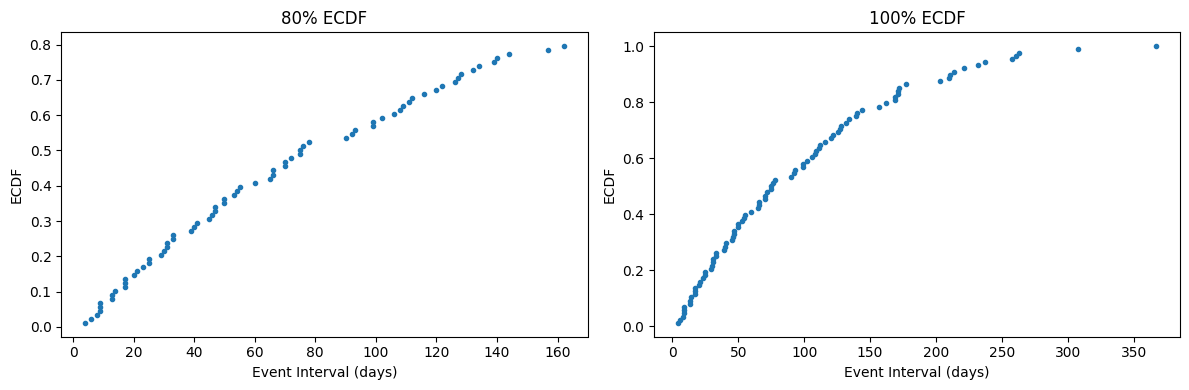

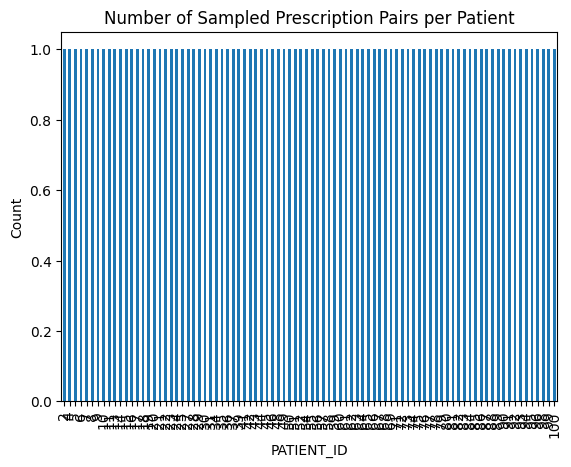

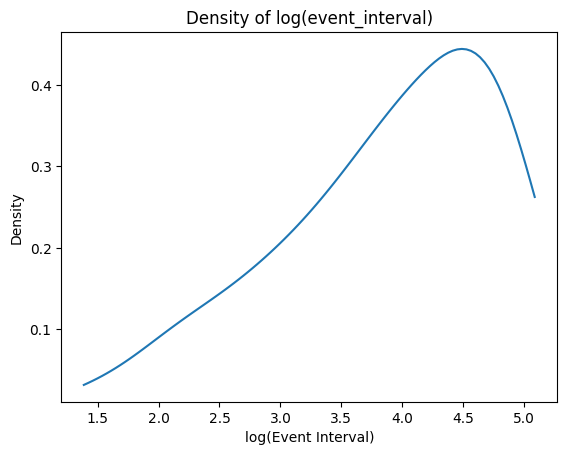

Optimal number of clusters (silhouette analysis): 2
Cluster Statistics:
   cluster  Minimum  Maximum  Median
0        0      4.0    120.0    47.0
1        1    122.0    367.0   171.0


C:\Users\Aris\AppData\Local\Temp\ipykernel_14900\4141963939.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = df_sample.groupby('PATIENT_ID').apply(lambda x: x.sample(1, random_state=1234)).reset_index(drop=True)


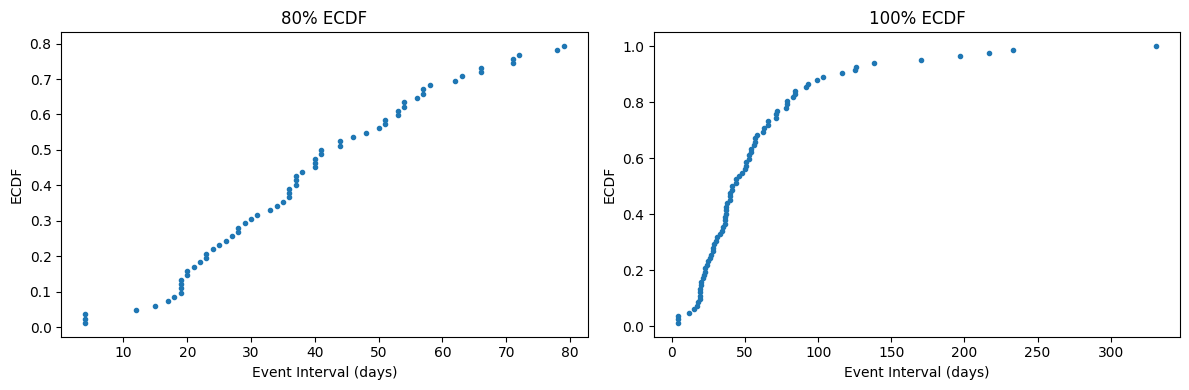

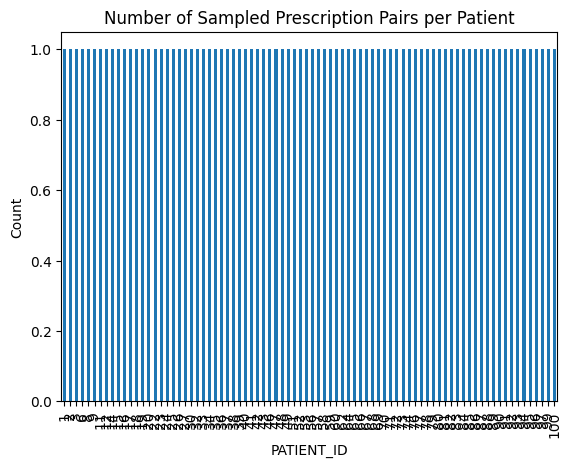

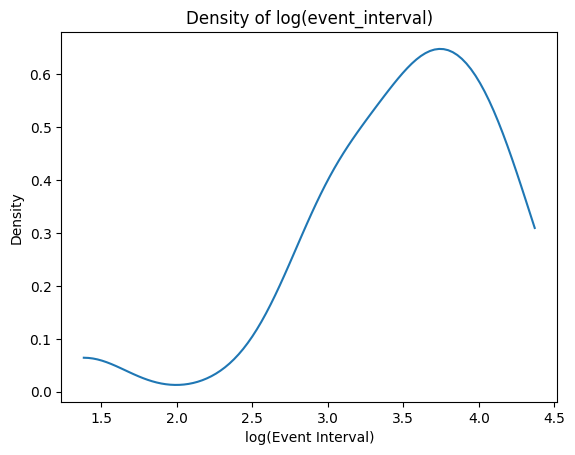

Optimal number of clusters (silhouette analysis): 2
Cluster Statistics:
   cluster  Minimum  Maximum  Median
0        0      4.0    103.0    40.0
1        1    116.0    331.0   170.0


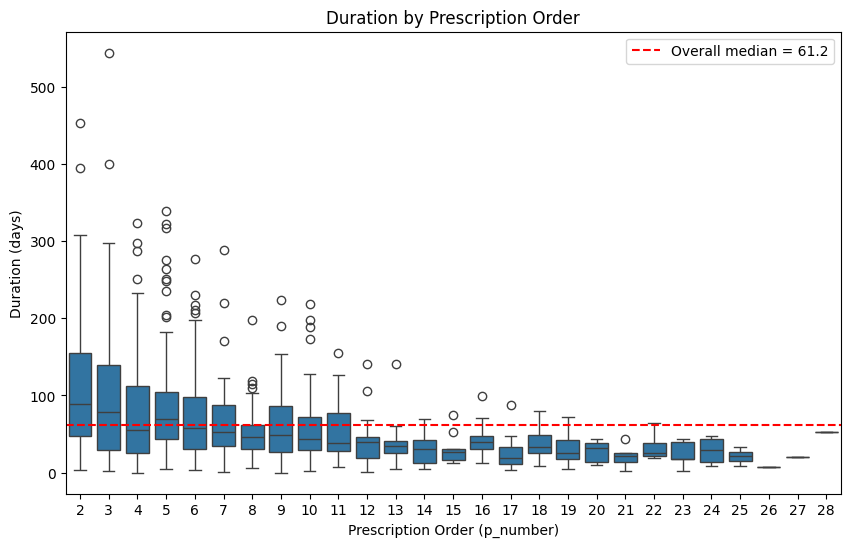

<Figure size 640x480 with 0 Axes>

In [5]:
# Load your data from the CSV file located at "data/med_events.csv"
df = pd.read_csv("data/med_events.csv")

# Inspect the first few rows of the data
print(df.head())

# Compute SEE estimates for specific medication categories, e.g., "medA" and "medB"
medA_estimates = see_estimator("medA", df)
medB_estimates = see_estimator("medB", df)

# Visualize the assumption check for the entire dataset
fig = see_assumption(df)
